# Statistical Modelling : Generalized Additive Model (GAM) with XG Boosting

**Author**: Muhammad Faran Khalid

In this notebook I'm using a Generalized Additive Model (GAM) for predicting TOC in various lakes and catchment areas present in our dataset. I'm using a LinearGAM model from the ***pygam*** library

In [1]:
!pip install pygam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.2/522.2 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 9.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
orbax-checkpoint 0.4.4 requires jax>=0.4.9, but you have jax 0.3.25 which is incompatible.
pandas-gbq 0.19.2 requires google-auth-oauthlib>=0.7.0, but you have google-auth-oauthlib 0.4.6 which is incompatible.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.26.2 which

In [2]:
!pip install numpy==1.23.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 16.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.2
    Uninstalling numpy-1.26.2:
      Successfully uninstalled numpy-1.26.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
orbax-checkpoint 0.4.4 requires jax>=0.4.9, but you have jax 0.3.25 which is incompatible.
pandas-gbq 0.19.2 requires google-auth-oauthlib>=0.7.0, but you have google-auth-oauthlib 0.4.6 which is incompatible.
pygam 0.9.0 requires numpy<2.0.0,>=1.24.2, but you have numpy 1.23.5 which is incompatible.


In [3]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics import explained_variance_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import seaborn as sns
import xgboost as xgb
from pygam import LinearGAM, s, te, f
from functools import reduce

# 1. Loading and Joining Datasets

We have datasets for various lakes which holds data regarding their water chemistry, weather, landscape etc. Most of it was joined during initial phase of the project. Now just joining the remaining weather dataset.

*MD-MVM Id* is the unique identifier of lakes in our dataset

In [4]:
# Loading the datasets
df1 = pd.read_csv('/content/drive/MyDrive/Model Data/Final_Merged_Dataset_With_WRT.csv')
df2 = pd.read_csv('/content/drive/MyDrive/Model Data/weather_data_clean.csv')

# Renaming column for consistency
df2.rename(columns={'Sample date': 'Date'}, inplace=True)

# Merging selected columns to dataframe
columns_to_merge = ['MD-MVM Id', 'Date', 'Temp 1w avg', 'Temp 2w avg', 'Temp 4w avg',
                    'Temp 12w avg', 'Temp 52w avg', 'Precip 1w avg', 'Precip 2w avg',
                    'Precip 4w avg', 'Precip 12w avg', 'Precip 52w avg']
df2_subset = df2[columns_to_merge]

# Merging the dataframes on 'MD-MVM Id' and 'Date'
df_merged = df1.merge(df2_subset, on=['MD-MVM Id', 'Date'], how='left')

<ipython-input-4-236732f055da>:2: DtypeWarning: Columns (77) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv('/content/drive/MyDrive/Model Data/Final_Merged_Dataset_With_WRT.csv')


In [5]:
df_merged.head()

,Unnamed: 0_x,MD-MVM Id,Survey station,Latitude,Longitude,County,Municipality,MS_CD C3,Date,Year,...,Temp 1w avg,Temp 2w avg,Temp 4w avg,Temp 12w avg,Temp 52w avg,Precip 1w avg,Precip 2w avg,Precip 4w avg,Precip 12w avg,Precip 52w avg
0,0,54,Spjutsjön,60.638793,15.445276,Dalarnas län,Falun,WA42559716,2001-03-28,2001,...,-5.285714,-5.635714,-4.192857,-5.066667,5.641209,NaN,NaN,NaN,NaN,NaN
1,1,54,Spjutsjön,60.638793,15.445276,Dalarnas län,Falun,WA42559716,2001-05-21,2001,...,8.985714,11.342857,9.578571,2.153571,5.380220,NaN,NaN,NaN,NaN,NaN
2,2,54,Spjutsjön,60.638793,15.445276,Dalarnas län,Falun,WA42559716,2001-08-22,2001,...,16.700000,15.857143,15.828571,15.752381,5.734890,NaN,NaN,NaN,NaN,NaN
3,3,54,Spjutsjön,60.638793,15.445276,Dalarnas län,Falun,WA42559716,2001-10-15,2001,...,8.914286,9.371429,8.985714,12.829762,5.856319,NaN,NaN,NaN,NaN,NaN
4,4,54,Spjutsjön,60.638793,15.445276,Dalarnas län,Falun,WA42559716,2002-02-26,2002,...,-5.842857,-2.942857,-1.850000,-4.617857,5.262912,NaN,NaN,NaN,NaN,NaN


# 2. Cleaning the dataset

**2.1 Dropping columns and imputing values**

First we clean the dataset by dropping columns with 50% or more missing values. We also impute missing values with the median for numerical data.

In [6]:
# Dropping columns with 50% or more missing values
missing_percentage = df_merged.isnull().mean() * 100
columns_to_drop = missing_percentage[missing_percentage > 50].index
df_cleaned = df_merged.drop(columns=columns_to_drop)

# Imputing missing values for remaining columns
for column in df_cleaned.columns:
    if df_cleaned[column].isnull().any():
        if df_cleaned[column].dtype == 'object':
            mode_val = df_cleaned[column].mode()[0]
            df_cleaned[column].fillna(mode_val, inplace=True)
        else:
            median_val = df_cleaned[column].median()
            df_cleaned[column].fillna(median_val, inplace=True)

In [7]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8974 entries, 0 to 8973
Data columns (total 87 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Unnamed: 0_x                        8974 non-null   int64  
 1   MD-MVM Id                           8974 non-null   int64  
 2   Survey station                      8974 non-null   object 
 3   Latitude                            8974 non-null   float64
 4   Longitude                           8974 non-null   float64
 5   County                              8974 non-null   object 
 6   Municipality                        8974 non-null   object 
 7   MS_CD C3                            8974 non-null   object 
 8   Date                                8974 non-null   object 
 9   Year                                8974 non-null   int64  
 10  Month                               8974 non-null   int64  
 11  Day                                 8974 no

**2.2 Calculating correlation**

Now we calculate the correlation of all the features with TOC and select significant features i.e. features with correlation > 0.

<ipython-input-8-1f8800cebdb8>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_cleaned.corr()


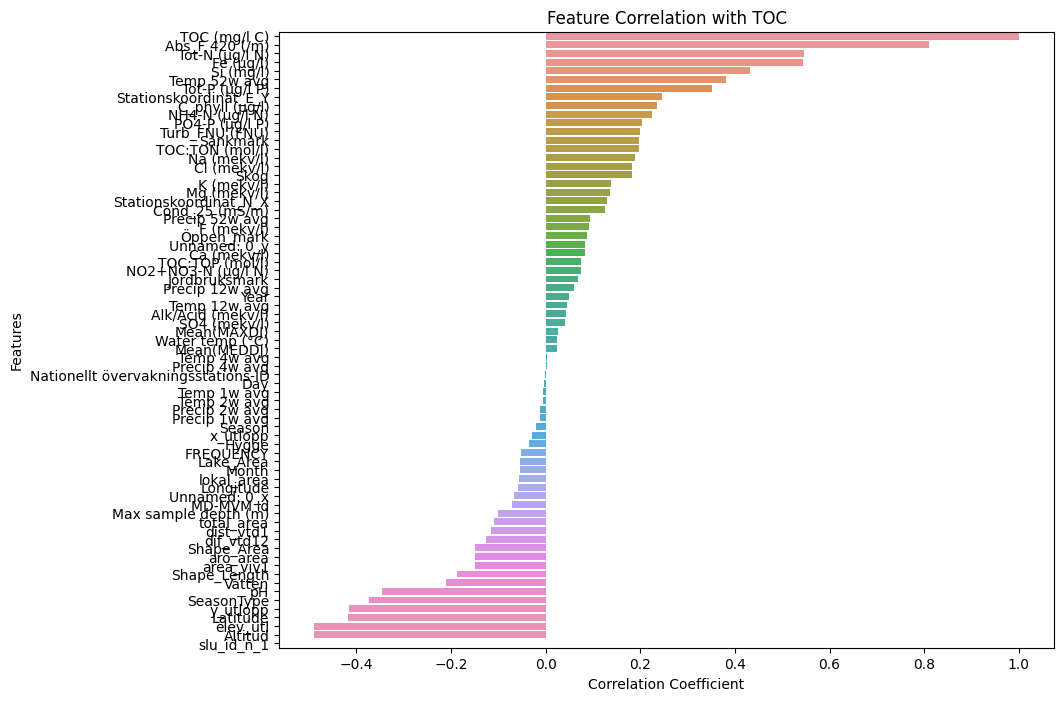

['Abs_F 420 (/m)',
 'Tot-N (µg/l N)',
 'Fe (µg/l)',
 'Si (mg/l)',
 'Temp 52w avg',
 'Tot-P (µg/l P)',
 'Stationskoordinat_E_Y',
 'C_phyll (µg/l)',
 'NH4-N (µg/l N)',
 'PO4-P (µg/l P)',
 'Turb_FNU (FNU)',
 'Sankmark',
 'TOC:TON (mol/l)',
 'Na (mekv/l)',
 'Cl (mekv/l)',
 'Skog',
 'K (mekv/l)',
 'Mg (mekv/l)',
 'Stationskoordinat_N_X',
 'Cond_25 (mS/m)',
 'Precip 52w avg',
 'F (mekv/l)',
 'Öppen_mark',
 'Unnamed: 0_y',
 'Ca (mekv/l)',
 'TOC:TOP (mol/l)',
 'NO2+NO3-N (µg/l N)',
 'Jordbruksmark',
 'Precip 12w avg',
 'Year',
 'Temp 12w avg',
 'Alk/Acid (mekv/l)',
 'SO4 (mekv/l)',
 'Mean(MAXDJ)',
 'Water temp (°C)',
 'Mean(MEDDJ)',
 'Temp 4w avg',
 'Precip 4w avg']

In [8]:
# Calculating correlation matrix
corr_matrix = df_cleaned.corr()

# 'TOC (mg/l C)' is the main feature
toc_corr = corr_matrix['TOC (mg/l C)']

# Sorting the correlations
sorted_toc_corr = toc_corr.sort_values(ascending=False)

# Plotting correlations
plt.figure(figsize=(10, 8))
sns.barplot(y=sorted_toc_corr.index, x=sorted_toc_corr.values)
plt.title('Feature Correlation with TOC')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()

# Selecting features with some significant correlation coefficient i.e. > 0
selected_features = sorted_toc_corr[sorted_toc_corr > 0].index.tolist()

selected_features.remove('TOC (mg/l C)')

selected_features

In [9]:
# updating dataframe to only include selected features
df_cleaned = df_cleaned[selected_features + ['TOC (mg/l C)']]

df_cleaned.head()

,Abs_F 420 (/m),Tot-N (µg/l N),Fe (µg/l),Si (mg/l),Temp 52w avg,Tot-P (µg/l P),Stationskoordinat_E_Y,C_phyll (µg/l),NH4-N (µg/l N),PO4-P (µg/l P),...,Year,Temp 12w avg,Alk/Acid (mekv/l),SO4 (mekv/l),Mean(MAXDJ),Water temp (°C),Mean(MEDDJ),Temp 4w avg,Precip 4w avg,TOC (mg/l C)
0,1.06,409.0,40.0,2.27,5.641209,8.0,763500,0.9,62.0,1.0,...,2001,-5.066667,0.078,0.131,3.85,0.6,1.5,-4.192857,1.614286,5.3
1,1.02,360.0,43.0,1.62,5.380220,5.0,763500,1.5,9.0,1.0,...,2001,2.153571,0.061,0.111,3.85,10.2,1.5,9.578571,1.614286,4.1
2,0.58,195.0,19.0,1.73,5.734890,5.0,763500,2.1,8.0,1.0,...,2001,15.752381,0.075,0.116,3.85,18.6,1.5,15.828571,1.614286,8.5
3,0.70,383.0,41.0,1.72,5.856319,8.0,763500,2.4,9.0,2.0,...,2001,12.829762,0.075,0.108,3.85,10.3,1.5,8.985714,1.614286,4.3
4,0.70,385.0,36.0,1.89,5.262912,8.0,763500,1.0,40.0,1.0,...,2002,-4.617857,0.075,0.118,3.85,1.5,1.5,-1.850000,1.614286,4.8


In [10]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8974 entries, 0 to 8973
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Abs_F 420 (/m)         8974 non-null   float64
 1   Tot-N (µg/l N)         8974 non-null   float64
 2   Fe (µg/l)              8974 non-null   float64
 3   Si (mg/l)              8974 non-null   float64
 4   Temp 52w avg           8974 non-null   float64
 5   Tot-P (µg/l P)         8974 non-null   float64
 6   Stationskoordinat_E_Y  8974 non-null   int64  
 7   C_phyll (µg/l)         8974 non-null   float64
 8   NH4-N (µg/l N)         8974 non-null   float64
 9   PO4-P (µg/l P)         8974 non-null   float64
 10  Turb_FNU (FNU)         8974 non-null   float64
 11  Sankmark               8974 non-null   float64
 12  TOC:TON (mol/l)        8974 non-null   float64
 13  Na (mekv/l)            8974 non-null   float64
 14  Cl (mekv/l)            8974 non-null   float64
 15  Skog

In [11]:
# Dropping unnamed columns
df_cleaned.drop(['Unnamed: 0_y'], axis=1, inplace=True)

<ipython-input-11-46877b1c524c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.drop(['Unnamed: 0_y'], axis=1, inplace=True)


In [12]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8974 entries, 0 to 8973
Data columns (total 38 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Abs_F 420 (/m)         8974 non-null   float64
 1   Tot-N (µg/l N)         8974 non-null   float64
 2   Fe (µg/l)              8974 non-null   float64
 3   Si (mg/l)              8974 non-null   float64
 4   Temp 52w avg           8974 non-null   float64
 5   Tot-P (µg/l P)         8974 non-null   float64
 6   Stationskoordinat_E_Y  8974 non-null   int64  
 7   C_phyll (µg/l)         8974 non-null   float64
 8   NH4-N (µg/l N)         8974 non-null   float64
 9   PO4-P (µg/l P)         8974 non-null   float64
 10  Turb_FNU (FNU)         8974 non-null   float64
 11  Sankmark               8974 non-null   float64
 12  TOC:TON (mol/l)        8974 non-null   float64
 13  Na (mekv/l)            8974 non-null   float64
 14  Cl (mekv/l)            8974 non-null   float64
 15  Skog

**2.3 Calculating VIF**

Finally we calculate the Variance Inflation Factor (VIF) to check the multicollinearity and to ensure the robustness of our model.

In [13]:
scaler = StandardScaler()

# Identifying numeric columns
numeric_cols = df_cleaned.select_dtypes(include=[np.number]).columns.tolist()

# Checking for Infinite Values
print("Infinite values in each column:\n", np.isinf(df_cleaned[numeric_cols]).sum())

# Replacing Infinite Values with NaN
df_cleaned[numeric_cols] = df_cleaned[numeric_cols].replace([np.inf, -np.inf], np.nan)

# Handling NaN Values
for column in numeric_cols:
    if df_cleaned[column].isnull().any():
        median_val = df_cleaned[column].median()
        df_cleaned[column].fillna(median_val, inplace=True)

df_cleaned[numeric_cols] = scaler.fit_transform(df_cleaned[numeric_cols])

# VIF Calculation
vif = pd.DataFrame()
vif["variables"] = numeric_cols
vif["VIF"] = [variance_inflation_factor(df_cleaned[numeric_cols].values, i) for i in range(df_cleaned[numeric_cols].shape[1])]

print(vif)


Infinite values in each column:
 Abs_F 420 (/m)             0
Tot-N (µg/l N)             0
Fe (µg/l)                  0
Si (mg/l)                  0
Temp 52w avg               0
Tot-P (µg/l P)             0
Stationskoordinat_E_Y      0
C_phyll (µg/l)             0
NH4-N (µg/l N)             0
PO4-P (µg/l P)             0
Turb_FNU (FNU)             0
Sankmark                   0
TOC:TON (mol/l)            0
Na (mekv/l)                0
Cl (mekv/l)                0
Skog                       0
K (mekv/l)                 0
Mg (mekv/l)                0
Stationskoordinat_N_X      0
Cond_25 (mS/m)             0
Precip 52w avg             0
F (mekv/l)                 0
Öppen_mark                 0
Ca (mekv/l)                0
TOC:TOP (mol/l)          125
NO2+NO3-N (µg/l N)         0
Jordbruksmark              0
Precip 12w avg             0
Year                       0
Temp 12w avg               0
Alk/Acid (mekv/l)          0
SO4 (mekv/l)               0
Mean(MAXDJ)                0
Water temp

# 3. Training and Testing GAM model

**Initial Run**

We use ***LinearGAM*** model from the ***pygam*** library for predicting the *TOC*. In our initial run we split our cleaned dataset into training and testing sets. We also drop the categorical columns since they have no significance in predicting TOC and we want to only use numerical data. We also calculate the R^2, sMAPE and Accuracy on test set.

In [14]:
# calculating sMAPE
def smape(true, pred):
    denominator = np.abs(true) + np.abs(pred)
    diff = np.abs(true - pred) / denominator
    diff[denominator == 0] = 0.0
    return 200 * np.mean(diff)

In [15]:
# Splitting the data into features and target
X = df_cleaned.drop('TOC (mg/l C)', axis=1)
y = df_cleaned['TOC (mg/l C)']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Dropping Categorical Features
categorical_cols = X_train.select_dtypes(include=['object']).columns

X_train = X_train.drop(columns=categorical_cols)
X_test = X_test.drop(columns=categorical_cols)

# Fitting the GAM model using a default spline for all features
gam = LinearGAM().gridsearch(X_train.values, y_train.values)

# Predicting on the test set
y_pred = gam.predict(X_test)

# Calculating the metrics
r2 = explained_variance_score(y_test, y_pred)
smape_value = smape(y_test, y_pred)
accuracy = 1 - smape_value / 100

print(f'R^2: {r2:.4f}')
print(f'sMAPE: {smape_value:.4f}')
print(f'Accuracy: {accuracy:.4f}')


100% (11 of 11) |########################| Elapsed Time: 0:01:34 Time:  0:01:34


R^2: 0.9149
sMAPE: 30.7009
Accuracy: 0.6930


In [16]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    544.4552
Link Function:                     IdentityLink Log Likelihood:                                -67570.1369
Number of Samples:                         6281 AIC:                                           136231.1843
                                                AICc:                                          136335.1392
                                                GCV:                                                0.0409
                                                Scale:                                              0.0346
                                                Pseudo R-Squared:                                   0.9681
Feature Function                  Lam

<ipython-input-16-dec6a6acdaaa>:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


# 4. Ensemble Methods

To improve the accuracy of the model we use different ensemble methods like Bagging and Boosting. We will try to combine multiple models to reduce variance and bias which might lead to better accuracy and performance.

**4.1 Random Forest model**

First we implements the Random Forest model by using the *sklearn* library.

In [17]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fitting the model
rf_model.fit(X_train, y_train)

# Predicting on test set
rf_y_pred = rf_model.predict(X_test)

# Calculating metrics
rf_r2 = explained_variance_score(y_test, rf_y_pred)
rf_smape_value = smape(y_test, rf_y_pred)
rf_accuracy = 1 - rf_smape_value / 100

print(f'Random Forest R^2: {rf_r2:.4f}')
print(f'Random Forest sMAPE: {rf_smape_value:.4f}')
print(f'Random Forest Accuracy: {rf_accuracy:.4f}')

Random Forest R^2: 0.9439
Random Forest sMAPE: 33.4198
Random Forest Accuracy: 0.6658


**4.2 Gradient Boosting model**

Then we implements the Gradient Boosting model by using the *sklearn* library.

In [18]:
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Fitting the model
gb_model.fit(X_train, y_train)

# Predicting on test set
gb_y_pred = gb_model.predict(X_test)

# Calculating metrics
gb_r2 = explained_variance_score(y_test, gb_y_pred)
gb_smape_value = smape(y_test, gb_y_pred)
gb_accuracy = 1 - gb_smape_value / 100

print(f'Gradient Boosting R^2: {gb_r2:.4f}')
print(f'Gradient Boosting sMAPE: {gb_smape_value:.4f}')
print(f'Gradient Boosting Accuracy: {gb_accuracy:.4f}')

Gradient Boosting R^2: 0.9430
Gradient Boosting sMAPE: 39.8039
Gradient Boosting Accuracy: 0.6020


**4.3 xG Boost model**

Then we implements the xG Boost model by using the *xgboost* library.

In [19]:
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Fitting the model
xgb_model.fit(X_train, y_train)

# Predicting on test set
xgb_y_pred = xgb_model.predict(X_test)

# Calculating metrics
xgb_r2 = explained_variance_score(y_test, xgb_y_pred)
xgb_smape_value = smape(y_test, xgb_y_pred)
xgb_accuracy = 1 - xgb_smape_value / 100

print(f'XGBoost R^2: {xgb_r2:.4f}')
print(f'XGBoost sMAPE: {xgb_smape_value:.4f}')
print(f'XGBoost Accuracy: {xgb_accuracy:.4f}')

XGBoost R^2: 0.9625
XGBoost sMAPE: 28.7529
XGBoost Accuracy: 0.7125


# Regularization

**Hyper-tuned GAM model**

From the evalauation metrics and summary above we can see that our simple GAM model has an accuracy of around *70%*. To make sure that our model is not overfitting we perfrom regularization by assigning a smoothing parameter *(lam=1.0)* to spline terms for each feature instead of a default spline for each feature.

The *gridsearch* method optimizes the smoothing parameter which makes the model less likely to overfit.

In [20]:
# Dropping categorical features and splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
categorical_cols = X_train.select_dtypes(include=['object']).columns
X_train = X_train.drop(columns=categorical_cols)
X_test = X_test.drop(columns=categorical_cols)

# Creating a list of spline terms with a 'smoothing parameter' for each feature
terms = [s(i, lam=1.0) for i in range(X_train.shape[1])]

# Combining the terms into a TermList
gam_terms = reduce(lambda x, y: x + y, terms)

# Defining and fitting the GAM model with combined terms
gam = LinearGAM(gam_terms).gridsearch(X_train.values, y_train.values)

# Predicting on the test set
y_pred = gam.predict(X_test)

# Calculating the metrics
r2_tuning = explained_variance_score(y_test, y_pred)
smape_value_tuning = smape(y_test, y_pred)
accuracy_tuning = 1 - smape_value / 100

print(f'R^2: {r2_tuning:.4f}')
print(f'sMAPE: {smape_value_tuning:.4f}')
print(f'Accuracy: {accuracy_tuning:.4f}')

100% (11 of 11) |########################| Elapsed Time: 0:01:16 Time:  0:01:16


R^2: 0.9149
sMAPE: 30.7009
Accuracy: 0.6930


**4.4 Combined Hyper-tuned GAM and xG Boost model**

From above we can see that simple GAM and hyper-tuner GAM model (regularization) has an accuracy of around 70% and xG Boost model has slightly higher accuracy of around 71.5%. So we combine these models to acheive better accuracy and performance.

In [21]:
# Dropping categorical features and splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
categorical_cols = X_train.select_dtypes(include=['object']).columns
X_train = X_train.drop(columns=categorical_cols)
X_test = X_test.drop(columns=categorical_cols)

# Creating a list of spline terms with a 'smoothing parameter' for each feature
terms = [s(i, lam=1.0) for i in range(X_train.shape[1])]

# Combining the terms into a TermList
gam_terms = reduce(lambda x, y: x + y, terms)

# Defining and fitting the GAM model with combined terms
gam = LinearGAM(gam_terms).gridsearch(X_train.values, y_train.values)

# Predicting on the training and test set with GAM
gam_train_pred = gam.predict(X_train)
gam_test_pred = gam.predict(X_test)

# Adding GAM predictions as a feature
X_train['GAM_Prediction'] = gam_train_pred
X_test['GAM_Prediction'] = gam_test_pred

# Defining XGBoost model
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Fitting the XGBoost model on augmented training data
xgb_model.fit(X_train, y_train)

# Making predictions
xgb_y_pred = xgb_model.predict(X_test)

# Calculating metrics
combined_r2 = explained_variance_score(y_test, xgb_y_pred)
combined_mse = mean_squared_error(y_test, xgb_y_pred)
combined_smape_value = smape(y_test, xgb_y_pred)
combined_accuracy = 1 - combined_smape_value / 100

print(f'Combined Model R^2: {combined_r2:.4f}')
print(f'Combined Model MSE: {combined_mse:.4f}')
print(f'Combined Model sMAPE: {combined_smape_value:.4f}')
print(f'Combined Model Accuracy: {combined_accuracy:.4f}')

100% (11 of 11) |########################| Elapsed Time: 0:01:09 Time:  0:01:09


Combined Model R^2: 0.9584
Combined Model MSE: 0.0425
Combined Model sMAPE: 24.6507
Combined Model Accuracy: 0.7535


We compare all the models we have implemented so far based on the evaluation metrics **(R^2, sMAPE and Accuracy)**.

We can clearly see that the **Combined GAM and xG Boost Model** increases the accuracy of our model up to **75%**.

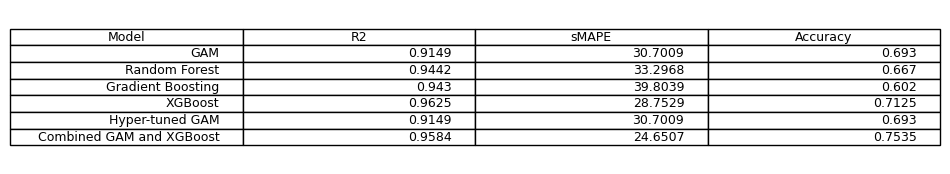

In [22]:
model_performance = {
    "Model": ["GAM", "Random Forest", "Gradient Boosting", "XGBoost", "Hyper-tuned GAM", "Combined GAM and XGBoost"],
    "R2": [0.9149, 0.9442, 0.9430, 0.9625, 0.9149, 0.9584],
    "sMAPE": [30.7009, 33.2968, 39.8039, 28.7529, 30.7009, 24.6507],
    "Accuracy": [0.6930, 0.6670, 0.6020, 0.7125, 0.6930, 0.7535]
}

df_performance = pd.DataFrame(model_performance)

# Plotting the table
fig, ax = plt.subplots(figsize=(12, 2))  # Adjust size as needed
ax.axis('tight')
ax.axis('off')
ax.table(cellText=df_performance.values, colLabels=df_performance.columns, loc='center')

plt.show()

**4.5 Model iterations**

Now we run 10 iterations of the combined model to find the best, worst and mean for all the evaluation metrics. i.e. R^2, sMAPE and Accuracy which is calculated as (1 - sMAPE / 100)

In [23]:
# Storing metrics for each iteration
r2_scores = []
smape_scores = []
accuracy_scores = []

# Simulating the model 10 times
for i in range(10):
    # Splitting the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
    categorical_cols = X_train.select_dtypes(include=['object']).columns

    # Dropping Categorical Features
    X_train = X_train.drop(columns=categorical_cols)
    X_test = X_test.drop(columns=categorical_cols)

    # Fitting the GAM model using a default spline for all features
    gam = LinearGAM().gridsearch(X_train.values, y_train.values)

    # Predicting on the training and test set with GAM
    gam_train_pred = gam.predict(X_train)
    gam_test_pred = gam.predict(X_test)

    # Adding GAM predictions as a feature
    X_train['GAM_Prediction'] = gam_train_pred
    X_test['GAM_Prediction'] = gam_test_pred

    # Defining XGBoost model
    xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

    # Fitting XGBoost model on augmented training data
    xgb_model.fit(X_train, y_train)

    # Making predictions
    xgb_y_pred = xgb_model.predict(X_test)

    # Calculating metrics
    combined_r2 = explained_variance_score(y_test, xgb_y_pred)
    combined_smape_value = smape(y_test, xgb_y_pred)
    combined_accuracy = 1 - combined_smape_value / 100

    # Appending metrics in lists
    r2_scores.append(combined_r2)
    smape_scores.append(combined_smape_value)
    accuracy_scores.append(combined_accuracy)

    print(f"Iteration {i+1}:")
    print(f"  R2: {combined_r2}")
    print(f"  sMAPE: {combined_smape_value}")
    print(f"  Accuracy: {combined_accuracy}\n")

# Calculating best, worst, and mean values of the metrics
print("Best R2:", max(r2_scores))
print("Worst R2:", min(r2_scores))
print("Mean R2:", np.mean(r2_scores))
print("Best sMAPE:", min(smape_scores))
print("Worst sMAPE:", max(smape_scores))
print("Mean sMAPE:", np.mean(smape_scores))
print("Best Accuracy:", max(accuracy_scores))
print("Worst Accuracy:", min(accuracy_scores))
print("Mean Accuracy:", np.mean(accuracy_scores))

100% (11 of 11) |########################| Elapsed Time: 0:01:07 Time:  0:01:07
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Iteration 1:
  R2: 0.922162254512688
  sMAPE: 26.163041449990327
  Accuracy: 0.7383695855000967



100% (11 of 11) |########################| Elapsed Time: 0:01:20 Time:  0:01:20
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Iteration 2:
  R2: 0.9232869564157407
  sMAPE: 26.08183251073457
  Accuracy: 0.7391816748926543



100% (11 of 11) |########################| Elapsed Time: 0:01:06 Time:  0:01:06
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Iteration 3:
  R2: 0.934289370511549
  sMAPE: 25.313919629816606
  Accuracy: 0.7468608037018339



100% (11 of 11) |########################| Elapsed Time: 0:01:10 Time:  0:01:10
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Iteration 4:
  R2: 0.9172214106792241
  sMAPE: 27.10870888541732
  Accuracy: 0.7289129111458268



100% (11 of 11) |########################| Elapsed Time: 0:01:08 Time:  0:01:08
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Iteration 5:
  R2: 0.9358302755067389
  sMAPE: 25.37074122993782
  Accuracy: 0.7462925877006218



100% (11 of 11) |########################| Elapsed Time: 0:01:09 Time:  0:01:09
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Iteration 6:
  R2: 0.9377431874170712
  sMAPE: 24.213803298965782
  Accuracy: 0.7578619670103421



100% (11 of 11) |########################| Elapsed Time: 0:01:12 Time:  0:01:12
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Iteration 7:
  R2: 0.9495736881210639
  sMAPE: 24.668830081751818
  Accuracy: 0.7533116991824819



100% (11 of 11) |########################| Elapsed Time: 0:01:19 Time:  0:01:19
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Iteration 8:
  R2: 0.9240604173733384
  sMAPE: 24.94383458986728
  Accuracy: 0.7505616541013272



100% (11 of 11) |########################| Elapsed Time: 0:01:08 Time:  0:01:08
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Iteration 9:
  R2: 0.9276544713948239
  sMAPE: 26.310541286030283
  Accuracy: 0.7368945871396972



100% (11 of 11) |########################| Elapsed Time: 0:01:08 Time:  0:01:08


Iteration 10:
  R2: 0.9333502528847041
  sMAPE: 26.264064414273225
  Accuracy: 0.7373593558572678

Best R2: 0.9495736881210639
Worst R2: 0.9172214106792241
Mean R2: 0.9305172284816943
Best sMAPE: 24.213803298965782
Worst sMAPE: 27.10870888541732
Mean sMAPE: 25.643931737678503
Best Accuracy: 0.7578619670103421
Worst Accuracy: 0.7289129111458268
Mean Accuracy: 0.743560682623215


# 5. Visualizations

Below are the plots to visualize the perfromance of our Combined hyper-tuned GAM and xG Boost model.

**5.1 Actual vs Predicted Scatter Plot**

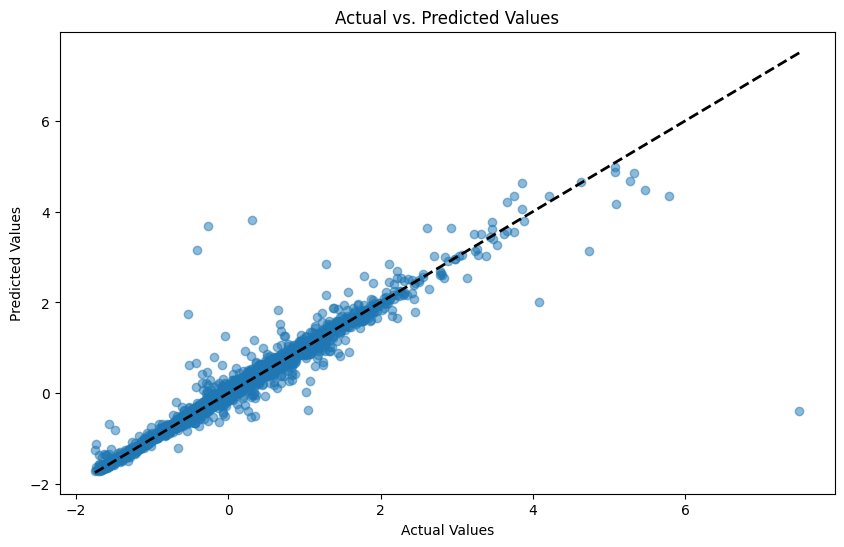

In [24]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, xgb_y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()

**5.2 Density Plot**

<ipython-input-25-001fd7a05eca>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(xgb_y_pred, label='Predicted Values', shade=True)
<ipython-input-25-001fd7a05eca>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_test, label='Actual Values', shade=True)


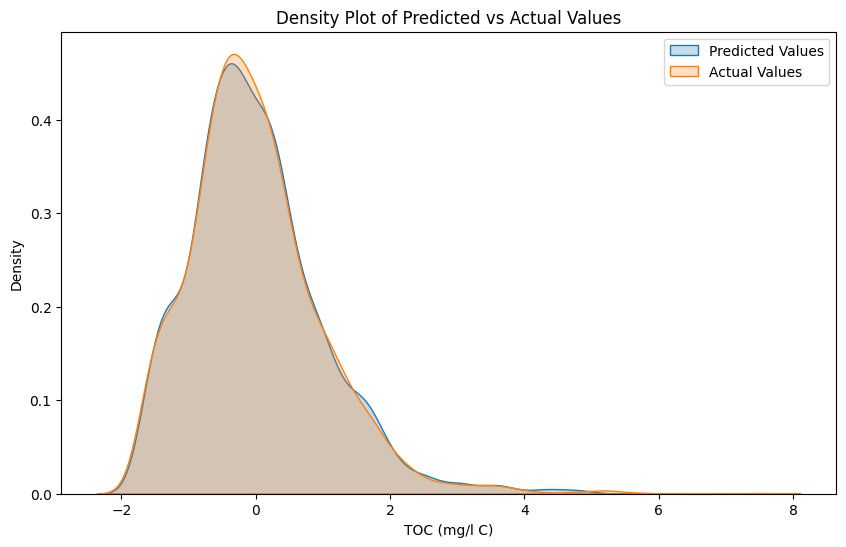

In [25]:
plt.figure(figsize=(10, 6))
sns.kdeplot(xgb_y_pred, label='Predicted Values', shade=True)
sns.kdeplot(y_test, label='Actual Values', shade=True)
plt.title('Density Plot of Predicted vs Actual Values')
plt.xlabel('TOC (mg/l C)')
plt.ylabel('Density')
plt.legend()
plt.show()

# Conclusion

We initially started with implementation of Generalized Additive Model (GAM) to predict the TOC for our combined lakes dataset (Lake chemistry, Hydrology, Weather, Landscape). Initially our model performed with an accuracy of around **70%** but with the help of techniques like regularization, ensemble methods (bagging, boosting, models combination) we managed to acheieve an accuracy around **75%**, which is significantly better in the context of our scaenario.